# Model Selection

## Import libraries and datasets

In [1]:
# Import libraries
import pandas as pd # For placing the data into dataframes for analysis
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools as itl
import sklearn
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, make_scorer
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline


# Fix display settings for viewing output
pd.set_option('display.max_columns', 160)
pd.set_option('display.max_rows', 400)

In [2]:
# Import training datasets
X_train = pd.read_csv("../datasets/X_train.csv")
y_train = pd.read_csv("../datasets/y_train.csv")
X_val = pd.read_csv("../datasets/X_val.csv")
y_val = pd.read_csv("../datasets/y_val.csv")

In [3]:
# Check on imported X train
X_train.head()

,loan_amnt,term,int_rate,inq_last_6mths,inq_last_12m,acc_open_past_24mths,bc_open_to_buy,mo_sin_old_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_rev_tl_bal_gt_0,percent_bc_gt_75,tot_hi_cred_lim,total_dti_consol,sub_grade_d,fico_median,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified
0,28000.0,60.0,10.78,1.0,3.0,8.0,31708.0,253.0,6.0,5.0,6.0,4.0,16.7,426839.0,22.72,24,767.0,1,0,0,0,0,0
1,5000.0,36.0,7.62,0.0,0.0,2.0,7483.0,341.0,6.0,5.0,69.0,3.0,0.0,319093.0,14.13,13,717.0,1,0,0,0,0,1
2,15000.0,36.0,7.89,0.0,0.0,4.0,7260.0,175.0,7.0,1.0,25.0,4.0,25.0,316999.0,6.55,15,707.0,1,0,0,0,0,0
3,15000.0,36.0,12.74,0.0,2.0,4.0,4647.0,380.0,11.0,1.0,20.0,5.0,33.3,68940.0,23.11,31,697.0,1,0,0,0,1,0
4,20000.0,36.0,8.39,0.0,0.0,0.0,294.0,233.0,30.0,5.0,92.0,13.0,100.0,24700.0,8.54,15,672.0,1,0,0,0,0,1


In [4]:
X_train.dtypes

loan_amnt                              float64
term                                   float64
int_rate                               float64
inq_last_6mths                         float64
inq_last_12m                           float64
acc_open_past_24mths                   float64
bc_open_to_buy                         float64
mo_sin_old_rev_tl_op                   float64
mo_sin_rcnt_tl                         float64
mort_acc                               float64
mths_since_recent_bc                   float64
num_rev_tl_bal_gt_0                    float64
percent_bc_gt_75                       float64
tot_hi_cred_lim                        float64
total_dti_consol                       float64
sub_grade_d                              int64
fico_median                            float64
home_ownership_MORTGAGE                  int64
home_ownership_NONE                      int64
home_ownership_OWN                       int64
home_ownership_RENT                      int64
verification_

In [5]:
X_train.shape

(713403, 23)

In [6]:
# Check on imported y train
y_train.head()

,loan_status
0,1
1,0
2,0
3,0
4,0


In [7]:
y_train.dtypes

loan_status    int64
dtype: object

In [8]:
y_train = np.ravel(y_train)

In [9]:
y_train.shape

(713403,)

In [10]:
# Check on imported X validation set
X_val.head()

,loan_amnt,term,int_rate,inq_last_6mths,inq_last_12m,acc_open_past_24mths,bc_open_to_buy,mo_sin_old_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_rev_tl_bal_gt_0,percent_bc_gt_75,tot_hi_cred_lim,total_dti_consol,sub_grade_d,fico_median,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified
0,7000.0,36.0,8.39,0.0,2.0,5.0,5852.0,166.0,6.0,1.0,12.0,5.0,50.0,26024.0,11.39,21,677.0,1,0,0,0,1,0
1,5600.0,36.0,12.79,1.0,9.0,6.0,6802.0,192.0,2.0,1.0,2.0,3.0,0.0,46355.0,14.62,31,682.0,0,0,0,1,0,1
2,8000.0,36.0,12.49,0.0,0.0,4.0,648.0,228.0,8.0,2.0,22.0,4.0,50.0,102218.0,19.80,24,662.0,1,0,0,0,1,0
3,11000.0,36.0,10.99,1.0,0.0,4.0,1118.0,169.0,4.0,1.0,10.0,7.0,80.0,122206.0,14.42,23,662.0,1,0,0,0,0,0
4,10400.0,36.0,8.18,0.0,0.0,7.0,866.0,60.0,8.0,0.0,39.0,3.0,100.0,83692.0,31.46,21,682.0,0,0,0,1,1,0


In [11]:
X_val.dtypes

loan_amnt                              float64
term                                   float64
int_rate                               float64
inq_last_6mths                         float64
inq_last_12m                           float64
acc_open_past_24mths                   float64
bc_open_to_buy                         float64
mo_sin_old_rev_tl_op                   float64
mo_sin_rcnt_tl                         float64
mort_acc                               float64
mths_since_recent_bc                   float64
num_rev_tl_bal_gt_0                    float64
percent_bc_gt_75                       float64
tot_hi_cred_lim                        float64
total_dti_consol                       float64
sub_grade_d                              int64
fico_median                            float64
home_ownership_MORTGAGE                  int64
home_ownership_NONE                      int64
home_ownership_OWN                       int64
home_ownership_RENT                      int64
verification_

In [12]:
X_val.shape

(178351, 23)

In [13]:
# Check on imported y validation set
y_val.head()

,loan_status
0,1
1,0
2,0
3,0
4,0


In [14]:
y_val.dtypes

loan_status    int64
dtype: object

In [15]:
y_val = np.ravel(y_val)

In [16]:
y_val.shape

(178351,)

### Scale features

In [17]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_val_sc = ss.transform(X_val)

### Imbalance classes
Will look into the proportion of classes in the target to see if it needs to be addressed as the model is to be used for predictive purposes

In [18]:
# Get proportions of data for training data
x = np.array(y_train)
y = np.bincount(y_train)
ls_count_train = np.nonzero(y)[0]
np.vstack((ls_count_train,y[ls_count_train])).T

array([[     0, 565229],
       [     1, 148174]])

In [19]:
# Get proportions of data for validation data
x = np.array(y_val)
y = np.bincount(y_val)
ls_count_val = np.nonzero(y)[0]
np.vstack((ls_count_val,y[ls_count_val])).T

array([[     0, 141307],
       [     1,  37044]])

Both the training and validation data sets have a somewhat imbalance in class between those paid off and defaulted. The training set has about 26.2% defaults while the validation set has 20.8%. Will use Smote to 

In [20]:
#use smote to deal with imbalanced classes
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_sc, y_train)

In [50]:
X_train_sm.shape

(1130458, 23)

In [55]:
print(np.sum(y_train))
print((y_train).shape-np.sum(y_train))

148174
[565229]


In [57]:
print(np.sum(y_train_sm))
print((y_train_sm).shape-np.sum(y_train_sm))

565229
[565229]


In [ ]:
print(y_train_sm.value_count())

### Baseline - Logistic Regression

In [21]:
# Instantiate Logistic Regression Classifier
lr = LogisticRegression(solver = 'liblinear')

# setting the number of folds
kf = KFold(10)

In [46]:
# Fit Logistic Regression Classifier and compute prediction
# lr.fit(X_train_sm, y_train_sm)

base_pred_train = cross_val_score(lr, X_train_sm, y_train_sm, cv=kf)

In [65]:
auc_score = make_scorer(roc_auc_score)

In [66]:
base_pred_train_reg = cross_val_score(lr, X_train, y_train, cv=kf, scoring = 'roc_auc')

In [59]:
base_pred_train_reg.mean()

0.7953835336044053

In [60]:
base_pred_train_reg

array([0.79, 0.8 , 0.79, 0.79, 0.79, 0.8 , 0.8 , 0.79, 0.8 , 0.8 ])

In [60]:
base_pred_train_reg.

array([0.79, 0.8 , 0.79, 0.79, 0.79, 0.8 , 0.8 , 0.79, 0.8 , 0.8 ])

In [49]:
base_pred_train.mean()

0.6038728348283102

In [61]:
base_pred_train

array([0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.54, 0.54, 0.54])

In [47]:
# calcluate the AUROC for the training set
base_train_roc = roc_auc_score(y_train_sm, base_pred_train[:,1])
print('For the training set the AUROC is:' + str(base_train_roc)+ '\n' )

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [24]:
# predicting results on validation set
base_pred_val = lr.predict_proba(X_val_sc)

In [25]:
# calculate the AUROC for the validation set
base_test_roc = roc_auc_score(y_val, base_pred_val[:,1])
print('For the hold-out set the AUROC is:' + str(base_test_roc))

For the hold-out set the AUROC is:0.7238476513256076


In [26]:
# function to display confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    '''Function to display confusion matrix from sickit learn
    documentation'''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itl.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.grid(False)

Confusion matrix, without normalization
[[94834 46473]
 [12801 24243]]


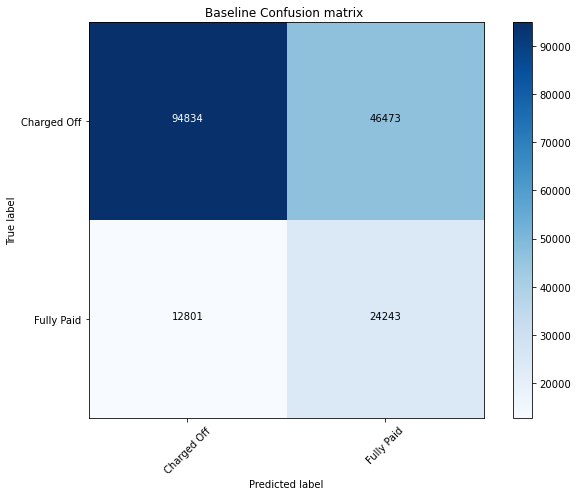

In [27]:
# Compute confusion matrix
cnf_matrix= confusion_matrix(y_val, lr.predict(X_val_sc))
class_names = ['Charged Off', "Fully Paid"]
np.set_printoptions(precision=2)

# Plot hold out set confusion matrix
plt.figure(figsize = (9,7))
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Baseline Confusion matrix ')

## Gridsearch fit and test models

In [28]:
def classification_model(model, param_grid, score = 'roc_auc'):
    
    # setting the number of folds
    kf = KFold(10, random_state=1)
    
    # Instantiate the GridSearchCV object: cv
    model_cv = GridSearchCV(model, param_grid, cv = kf, scoring = score, 
                            return_train_score = True, n_jobs = -3)
    
    # Fitting the training set 
    model_cv.fit(X_train_sm.astype(float), y_train_sm.astype(float))
        
    # Predict the labels of the test set: y_pred        
    y_pred = model_cv.predict_proba(X_val_sc.astype(float))[:,1]
    
    # Printing best parametrs
    print("Tuned Model Parameters: {}".format(model_cv.best_params_))
    
     # Printing the corresponding AUROC "
    test_roc = roc_auc_score(y_val, y_pred)
    print('The hold-out set AUROC = ' + str(test_roc))
    
    # Compute confusion matrix
    cnf_matrix= confusion_matrix(y_val, model_cv.predict(X_val_sc.astype(float)))
    class_names = ['Charged Off', "Fully Paid"]
    np.set_printoptions(precision=2)

    # Plot hold out set confusion matrix
    plt.figure(figsize = (9,7))
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Hold-out set Confusion matrix ')
    
    return pd.DataFrame(model_cv.cv_results_)

### K Nearest Neighbours

In [ ]:
# K Nearest Neighbours model hyperparameter tuning
knn = KNeighborsClassifier()# Instantiate K Nearest Neighbours model
params = {
    'n_neighbors': range(8,12),
    'weights':['uniform'],
    'leaf_size': range(28, 32),
     'algorithm': ['auto'] # Set params for gridsearch
    }
gs_knn = GridSearchCV(knn, param_grid = params, scoring='balanced_accuracy', verbose=1, return_train_score=True)
gs_knn.fit(X_train_sc, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
# cross_val_score(knn, X_train_sc, y_train, cv=10).mean()

In [ ]:
# knn.fit(X_val_sc, y_val)

In [ ]:
# cross_val_score(knn, X_val_sc, y_val, cv=10).mean()

### AdaBoost

In [18]:
ada = AdaBoostClassifier()
pipe_params_ada = {
                'learning_rate': [0.9, 1.0],
                'n_estimators': [30, 50],
                'random_state': [42]
                }
# gs_ada = GridSearchCV(ada, param_grid=pipe_params_ada, scoring='roc_auc', cv=5, return_train_score= True, n_jobs = -1, verbose=1)
gs_ada = GridSearchCV(ada, param_grid=pipe_params_ada, scoring='balanced_accuracy', cv=5, return_train_score= True, verbose=1)
gs_ada.fit(X_train_sc, y_train)
print(gs_ada.best_score_)
gs_ada.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  8.4min finished


0.2161049280814465


{'learning_rate': 1.0, 'n_estimators': 50, 'random_state': 42}

In [ ]:
ada = AdaBoostClassifier()
pipe_params_ada = {
                'learning_rate': [1.2, 1.6],
                'n_estimators': [60, 80],
                'random_state': [42]
                }
# gs_ada = GridSearchCV(ada, param_grid=pipe_params_ada, scoring='roc_auc', cv=5, return_train_score= True, n_jobs = -1, verbose=1)
gs_ada = GridSearchCV(ada, param_grid=pipe_params_ada, scoring='balanced_accuracy', cv=5, return_train_score= True, verbose=1)
gs_ada.fit(X_train_sc, y_train)
print(gs_ada.best_score_)
gs_ada.best_params_

### Gradient Boost

In [19]:
gbc = GradientBoostingClassifier()
pipe_params_gbc = {
                'learning_rate': [0.3,0.5],
                'max_depth': [2,3],
                'min_samples_leaf': [1,2],
                'n_estimators': [50,100],
                'random_state': [42],
                'max_features': ['auto']
                }
gs_gbc = GridSearchCV(gbc, param_grid=pipe_params_gbc, scoring='balanced_accuracy', cv=5, return_train_score= True, verbose=1)
gs_gbc.fit(X_train_sc, y_train)
print(gs_gbc.best_score_)
gs_gbc.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

### Bagging

In [ ]:
bbc = BalancedBaggingClassifier()
pipe_params_bbc = {
                'n_estimators': range(10,20),
                'max_samples': [1,3,5],
                'max_features': [1,3,5],
                'random_state': [42]
                }
gs_bbc = GridSearchCV(bbc, param_grid=pipe_params_bbc, scoring='balanced_accuracy', cv=5, return_train_score= True, verbose=1)
gs_bbc.fit(X_train_sc, y_train)
print(gs_bbc.best_score_)
gs_bbc.best_params_

In [ ]:
bc = BaggingClassifier()
pipe_params_bc = {
                'n_estimators': range(10,15),
                'max_samples': [3,7],
                'max_features': [3,7],
                'random_state': [42]
                }
gs_bc = GridSearchCV(bc, param_grid=pipe_params_bc, scoring='balanced_accuracy', cv=5, return_train_score= True, verbose=1)
gs_bc.fit(X_train_sc, y_train)
print(gs_bc.best_score_)
gs_bc.best_params_

### Random Forest

In [18]:
# Import rf_train dataset
rf_train = pd.read_csv("../datasets/rf_train.csv")

In [19]:
rf_train.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,loan_status,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,mths_since_last_major_derog,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,total_inc_consol,total_dti_consol,sub_grade_d,est_age_cr_line,fico_median,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,pymnt_plan_y,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,application_type_Joint App,disbursement_method_DirectPay,region_northeast,region_south,region_west
0,3600.0,36.0,13.99,123.03,3,10.0,1,0.0,1.0,30.0,0.0,7.0,0.0,2765.0,29.7,13.0,30.0,3.0,1.0,4.0,4.0,1506.0,37.2,148.0,128.0,3.0,3.0,1.0,4.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,55000.0,5.91,34,148,677.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,24700.0,36.0,11.99,820.28,3,10.0,1,1.0,4.0,6.0,0.0,22.0,0.0,21470.0,19.2,38.0,1.0,0.0,0.0,6.0,4.0,57830.0,27.1,113.0,192.0,2.0,2.0,4.0,2.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,65000.0,16.06,31,192,717.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,20000.0,60.0,10.78,432.66,2,10.0,1,0.0,0.0,0.0,0.0,6.0,0.0,7869.0,56.2,18.0,0.0,2.0,5.0,1.0,6.0,2737.0,55.9,125.0,184.0,14.0,14.0,5.0,101.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,134000.0,24.63,24,184,697.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,10400.0,60.0,22.45,289.91,6,3.0,1,1.0,3.0,12.0,0.0,12.0,0.0,21929.0,64.5,35.0,1.0,2.0,1.0,3.0,10.0,4567.0,77.5,128.0,210.0,4.0,4.0,6.0,4.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,104433.0,25.37,61,210,697.0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,11950.0,36.0,13.44,405.18,3,4.0,1,0.0,0.0,0.0,0.0,5.0,0.0,8822.0,68.4,6.0,0.0,0.0,0.0,0.0,0.0,844.0,91.0,338.0,54.0,32.0,32.0,0.0,36.0,2.0,3.0,2.0,2.0,2.0,4.0,4.0,3.0,5.0,100.0,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,34000.0,10.20,33,338,692.0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [20]:
rf_train.dtypes

loan_amnt                              float64
term                                   float64
int_rate                               float64
installment                            float64
grade                                    int64
emp_length                             float64
loan_status                              int64
delinq_2yrs                            float64
inq_last_6mths                         float64
mths_since_last_delinq                 float64
mths_since_last_record                 float64
open_acc                               float64
pub_rec                                float64
revol_bal                              float64
revol_util                             float64
total_acc                              float64
mths_since_last_major_derog            float64
inq_fi                                 float64
total_cu_tl                            float64
inq_last_12m                           float64
acc_open_past_24mths                   float64
bc_open_to_bu

In [21]:
rf_train.shape

(901852, 125)

In [22]:
X_rf_col = rf_train.drop(columns = 'loan_status').columns
X_rf = rf_train[X_rf_col]
y_rf = rf_train['loan_status']

In [23]:
feat_labels = X_rf.columns.tolist()
# feat_labels.index.tolist()
type(feat_labels)

list

In [24]:
# Train-validation split on the rf_train dataset
rf_X_train, rf_X_val, rf_y_train, rf_y_val = train_test_split(X_rf, y_rf, test_size=.2, stratify=y_rf, random_state=42)

In [25]:
# To scale data use for the model
ss = StandardScaler()
rf_X_train_sc = ss.fit_transform(rf_X_train)
rf_X_val_sc = ss.transform(rf_X_val)

In [26]:
# Create a random forest classifier
rfc = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)

# Train the classifier
rfc.fit(rf_X_train_sc, y_train)

# Print the name and gini importance of each feature
for feature in zip(feat_labels, rfc.feature_importances_):
    print(feature)

('loan_amnt', 0.023492706020756156)
('term', 0.015973879134550156)
('int_rate', 0.03708264001603949)
('installment', 0.027826386569094454)
('grade', 0.019633909565374447)
('emp_length', 0.013759597208474231)
('delinq_2yrs', 0.0058486320380014886)
('inq_last_6mths', 0.008169773290684934)
('mths_since_last_delinq', 0.015270763737893935)
('mths_since_last_record', 0.008332385348997624)
('open_acc', 0.015577151748882665)
('pub_rec', 0.004013000532307809)
('revol_bal', 0.026432212858311627)
('revol_util', 0.02610543225145921)
('total_acc', 0.020962102170684588)
('mths_since_last_major_derog', 0.01211708312406542)
('inq_fi', 0.006185016963523172)
('total_cu_tl', 0.006581331102772327)
('inq_last_12m', 0.009183531431357457)
('acc_open_past_24mths', 0.017670778285165455)
('bc_open_to_buy', 0.026549305863209034)
('bc_util', 0.02551480547013439)
('mo_sin_old_il_acct', 0.025886504591748925)
('mo_sin_old_rev_tl_op', 0.027191005881744886)
('mo_sin_rcnt_rev_tl_op', 0.019393512350309977)
('mo_sin_rcnt

In [27]:
# Create feature selector using random forest classifier
sfm = SelectFromModel(rfc)

# Train selector
sfm.fit(rf_X_train_sc, rf_y_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=1000, n_jobs=-1,
                                                 random_state=42))

In [28]:
# List out features which are important
sfm.get_support()
selected_feat= X_rf.columns[(sfm.get_support())]
print(len(selected_feat))
print(selected_feat)

44
Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'revol_bal', 'revol_util', 'total_acc',
       'mths_since_last_major_derog', 'inq_last_12m', 'acc_open_past_24mths',
       'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'tot_hi_cred_lim', 'total_bal_ex_mort',
       'total_bc_limit', 'total_il_high_credit_limit', 'total_inc_consol',
       'total_dti_consol', 'sub_grade_d', 'est_age_cr_line', 'fico_median'],
      dtype='object')


In [29]:
# Create new X train and X val with selected features
fs_X_train = sfm.transform(rf_X_train_sc)
fs_X_val = sfm.transform(rf_X_val_sc)

In [30]:
# Create a new random forest classifier for the most important features
rf_fs = RandomForestClassifier()

# Train the new classifier on the new dataset containing the most important features
rf_fs.fit(fs_X_train, y_train)

RandomForestClassifier()

In [ ]:
rf_fs.score(fs_X_train, y_train)

In [33]:
rf_params = {'min_samples_split': [3,5],
             'min_samples_leaf': range(15, 20, 1),
             'class_weight': ['balanced'],
             'n_estimators': [1000]}

gs_rf = GridSearchCV(rf_fs, param_grid=rf_params, scoring='accuracy', verbose=1)

In [35]:
gs_rf.fit(fs_X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [ ]:
gs_rf.score(fs_X_train, y_train), gs_rf.score(fs_X_val, y_val)

In [ ]:
gs_rf.best_params_

<span style="color:red">*Extra*</span>

In [ ]:
pd.Series(sel.estimator_.feature_importances_.ravel()).hist()

In [ ]:
# Create new X train and X val with selected features
fs_X_train = rf_X_train[]
fs_X_val = rf_X_val[]

In [ ]:
# To scale feature selected data use for the model
ss = StandardScaler()
fs_X_train_sc = ss.fit_transform(fs_X_train)
fs_X_val_sc = ss.transform(fs_X_val)

In [2]:
# Import training datasets
trains = pd.read_csv("../datasets/samp_train.csv")

In [22]:
# Import training datasets
trains = pd.read_csv("../datasets/samp_train_2.csv")

In [23]:
X_col = trains.drop(columns = 'loan_status').columns

In [24]:
X = trains[X_col]
y = trains['loan_status']

In [25]:
X.shape

(50000, 23)

In [26]:
y.shape

(50000,)

In [27]:
ss = StandardScaler()
X_sc = ss.fit_transform(X)

In [37]:
%%time
knn = KNeighborsClassifier()
# setting the number of folds
kf = KFold(5)
knn_auc_score = cross_val_score(knn, X_sc, y, cv=kf, scoring = 'roc_auc')

CPU times: user 43.8 s, sys: 24.7 s, total: 1min 8s
Wall time: 1min 5s


In [31]:
%%time
gbc = GradientBoostingClassifier()
# setting the number of folds
kf = KFold(5)
gbc_auc_score = cross_val_score(gbc, X_sc, y, cv=kf, scoring = 'roc_auc')

CPU times: user 36.3 s, sys: 75.3 ms, total: 36.4 s
Wall time: 36.4 s


In [29]:
%%time
svc = SVC()
kf = KFold(5)
svc_auc_score = cross_val_score(svc, X_sc, y, cv=kf, scoring = 'roc_auc')

CPU times: user 16min 2s, sys: 2.09 s, total: 16min 4s
Wall time: 16min 5s


In [35]:
%%time
sgd = SGDClassifier()
kf = KFold(5)
sgd_auc_score = cross_val_score(sgd, X_sc, y, cv=kf, scoring = 'roc_auc')

CPU times: user 3.98 s, sys: 570 ms, total: 4.55 s
Wall time: 727 ms


In [30]:
%%time
rf = RandomForestClassifier()
kf = KFold(5)
rf_auc_score = cross_val_score(rf, X_sc, y, cv=kf, scoring = 'roc_auc')

CPU times: user 26.7 s, sys: 58.2 ms, total: 26.7 s
Wall time: 26.7 s


In [36]:
print(knn_auc_score.mean())
print(gbc_auc_score.mean())
print(svc_auc_score.mean())
print(sgd_auc_score.mean())
print(rf_auc_score.mean())

0.628986756594012
0.7235652051301438
0.6281216389977522
0.6445723597819487
0.7063865849208173


In [ ]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

In [7]:
# Create a new random forest classifier for the most important features
rf = RandomForestClassifier()

In [48]:
%%time
# Train the new classifier on the new dataset containing the most important features
rf.fit(X, y)

CPU times: user 47.2 s, sys: 351 ms, total: 47.5 s
Wall time: 47.5 s


RandomForestClassifier()

In [49]:
rf.score(X, y)

0.99999

In [31]:
ss = StandardScaler()
X_sc = ss.fit_transform(X)

In [10]:
knn = KNeighborsClassifier()

In [11]:
%%time
knn.fit(X_sc, y)

CPU times: user 20.5 ms, sys: 16.4 ms, total: 36.9 ms
Wall time: 35.7 ms


KNeighborsClassifier()

In [13]:
# setting the number of folds
kf = KFold(10)

In [32]:
%%time
knn = KNeighborsClassifier()
# setting the number of folds
kf = KFold(2)
knn_auc_score = cross_val_score(knn, X_sc, y, cv=kf, scoring = 'roc_auc')

CPU times: user 3min 48s, sys: 1min 44s, total: 5min 33s
Wall time: 2min 26s


In [19]:
%%time
knn.fit(X_train_sc, y_train)

CPU times: user 10.1 s, sys: 27.6 ms, total: 10.2 s
Wall time: 10.1 s


KNeighborsClassifier()

In [18]:
X_train_sc.shape

(713403, 23)

In [2]:
# Import training datasets
X_train_ss_2 = pd.read_csv("../datasets/X_train_ss_2.csv")
y_train_ss_2 = pd.read_csv("../datasets/y_train_ss_2.csv")

In [6]:
y_train_ss_2 = np.ravel(y_train_ss_2)

In [7]:
# Initializing Classifiers
clf1 = LogisticRegression(multi_class='binomial',
                          solver='saga',
                          random_state=1)
clf2 = KNeighborsClassifier(algorithm='ball_tree',
                            leaf_size=50)
clf3 = RandomForestClassifier(random_state=1)
clf4 = GradientBoostingClassifier(max_features = 'auto',
                                  random_state=1)

# Building the pipelines
pipe1 = Pipeline([('std', StandardScaler()),
                  ('clf1', clf1)])

pipe2 = Pipeline([('std', StandardScaler()),
                  ('clf2', clf2)])

pipe4 = Pipeline([('std', StandardScaler()),
                  ('clf4', clf4)])


# Setting up the parameter grids
param_grid1 = [{'clf1__penalty': ['l2'],
                'clf1__C': np.power(10., np.arange(-4, 4))}]

param_grid2 = [{'clf2__n_neighbors': list(range(1, 10)),
                'clf2__p': [1, 2]}]

param_grid3 = [{'max_depth': list(range(1, 10)) + [None],
                'criterion': ['gini', 'entropy']}]

param_grid4 = [{'clf4__learning_rate': [0.1, 0.5, 1.0, 5.0],
                'clf4__n_estimators': [100, 200, 500, 1000],
                'clf4__max_depth': [3, 5, 10, 20]}]


# Setting up multiple GridSearchCV objects, 1 for each algorithm
gridcvs = {}

for pgrid, est, name in zip((param_grid1, param_grid2,
                             param_grid3, param_grid4),
                            (pipe1, pipe2, clf3, pipe4),
                            ('Log Reg', 'KNN', 'RandForest', 'Gradient Boost')):
    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       scoring='roc_auc',
                       n_jobs=1,
                       cv=2,
                       verbose=0,
                       refit=True)
    gridcvs[name] = gcv

In [ ]:
%%time
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

for name, gs_est in sorted(gridcvs.items()):
    nested_score = cross_val_score(gs_est, 
                                   X=X_train_ss_2, 
                                   y=y_train_ss_2, 
                                   cv=outer_cv,
                                   n_jobs=1)
    print('%s | outer AUC %.2f%% +/- %.2f' % 
          (name, nested_score.mean() * 100, nested_score.std() * 100))

In [3]:
n_rows = 300000

In [ ]:
samp_train = train_2.sample(n=n_rows)